# 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data Reading

In [2]:
apps_df = pd.read_csv('./data/googleplaystore.csv')
user_reviews_df = pd.read_csv('./data/googleplaystore_user_reviews.csv')

# 3. Data Exploration

In [3]:
apps_df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
user_reviews_df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


# 4. Data Cleaning

## A. Handling Noisy Data

### NOTE: Record 10472 has wrong inputs in `Category`, `Rating`, `Reviews`, `Size`, `Installs`, `Type`, `Price` thus it needs to be removed.

In [5]:
print(apps_df.loc[10472])
apps_df = apps_df.drop(10472)

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                                 19
Reviews                                              3.0M
Size                                               1,000+
Installs                                             Free
Type                                                    0
Price                                            Everyone
Content Rating                                        NaN
Genres                                  February 11, 2018
Last Updated                                       1.0.19
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object


### I. Removing `M`, `k`, `Varies with device` from `Size` column

In [6]:
apps_df['Size'].unique()

array(['19M', '14M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M',
       '28M', '12M', '20M', '21M', '37M', '2.7M', '5.5M', '17M', '39M',
       '31M', '4.2M', '7.0M', '23M', '6.0M', '6.1M', '4.6M', '9.2M',
       '5.2M', '11M', '24M', 'Varies with device', '9.4M', '15M', '10M',
       '1.2M', '26M', '8.0M', '7.9M', '56M', '57M', '35M', '54M', '201k',
       '3.6M', '5.7M', '8.6M', '2.4M', '27M', '2.5M', '16M', '3.4M',
       '8.9M', '3.9M', '2.9M', '38M', '32M', '5.4M', '18M', '1.1M',
       '2.2M', '4.5M', '9.8M', '52M', '9.0M', '6.7M', '30M', '2.6M',
       '7.1M', '3.7M', '22M', '7.4M', '6.4M', '3.2M', '8.2M', '9.9M',
       '4.9M', '9.5M', '5.0M', '5.9M', '13M', '73M', '6.8M', '3.5M',
       '4.0M', '2.3M', '7.2M', '2.1M', '42M', '7.3M', '9.1M', '55M',
       '23k', '6.5M', '1.5M', '7.5M', '51M', '41M', '48M', '8.5M', '46M',
       '8.3M', '4.3M', '4.7M', '3.3M', '40M', '7.8M', '8.8M', '6.6M',
       '5.1M', '61M', '66M', '79k', '8.4M', '118k', '44M', '695k', '1.6M',
     

In [7]:
# Removing `M`, Changing Size To KB
apps_df['Size'] = apps_df['Size'].map(
    lambda value :
        str(int(float(value.rstrip('M')) * 1024)) if value[-1] == 'M' else value
)

# Removing `k`
apps_df['Size'] = apps_df['Size'].map(
    lambda value :
        str(value.rstrip('k')) if value[-1] == 'k' else value
)

# Setting `Varies with device` to NaN
apps_df['Size'] = apps_df['Size'].map(
    lambda value :
        np.nan if value == 'Varies with device' else value
)

### II. Removing `+`, `,` from `Installs` column

In [8]:
apps_df['Installs'].unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '50+', '100+', '500+',
       '10+', '1+', '5+', '0+', '0'], dtype=object)

In [9]:
# Removing `+`
apps_df['Installs'] = apps_df['Installs'].map(
    lambda value :
        value.rstrip('+')
)

# Removing `,`
apps_df['Installs'] = apps_df['Installs'].map(
    lambda value :
        ''.join(value.split(','))
)

### III. Removing `$` from `Price` column

In [10]:
apps_df['Price'].unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', '$1.20', '$1.04'], dtype=object)

In [11]:
# Removing `$`
apps_df['Price'] = apps_df['Price'].map(
    lambda value :
        value.lstrip('$')
)

### IV. Changing Columns To Numeric

In [12]:
apps_df.describe()

,Rating
count,9366.000000
mean,4.191757
std,0.515219
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,5.000000


In [13]:
# Changing Values From String To Numeric in `Rating` Column
apps_df['Rating'] = pd.to_numeric(apps_df['Rating'])

# Changing Values From String To Numeric In `Reviews` Column
apps_df['Reviews'] = pd.to_numeric(apps_df['Reviews'])

# Changing Values From String To Numeric in `Size` Column
apps_df['Size'] = pd.to_numeric(apps_df['Size'])

# Changing Values From String To Numeric in `Installs` Column
apps_df['Installs'] = pd.to_numeric(apps_df['Installs'])

# Changing Values From String To Numeric in `Price` Column
apps_df['Price'] = pd.to_numeric(apps_df['Price'])

In [14]:
apps_df.describe()

,Rating,Reviews,Size,Installs,Price
count,9366.000000,1.084000e+04,9145.000000,1.084000e+04,10840.000000
mean,4.191757,4.441529e+05,22032.397212,1.546434e+07,1.027368
std,0.515219,2.927761e+06,23131.336868,8.502936e+07,15.949703
min,1.000000,0.000000e+00,8.500000,0.000000e+00,0.000000
25%,4.000000,3.800000e+01,5017.000000,1.000000e+03,0.000000
50%,4.300000,2.094000e+03,13312.000000,1.000000e+05,0.000000
75%,4.500000,5.477550e+04,30720.000000,5.000000e+06,0.000000
max,5.000000,7.815831e+07,102400.000000,1.000000e+09,400.000000


### Special Cases

In [15]:
# Should I handle Outliers?
# In Type there is 2 Unrated, 3 Adults +18. should they be removed?

## B. Handling Missing Values

In [16]:
apps_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
App               10840 non-null object
Category          10840 non-null object
Rating            9366 non-null float64
Reviews           10840 non-null int64
Size              9145 non-null float64
Installs          10840 non-null int64
Type              10839 non-null object
Price             10840 non-null float64
Content Rating    10840 non-null object
Genres            10840 non-null object
Last Updated      10840 non-null object
Current Ver       10832 non-null object
Android Ver       10838 non-null object
dtypes: float64(3), int64(2), object(8)
memory usage: 1.2+ MB


### I. Replacing `NaN` with `Free`, `Paid` in `Type` Column based on `Price` Column

In [17]:
apps_df['Type'].value_counts().head()

Free    10039
Paid      800
Name: Type, dtype: int64

In [18]:
# Replacing `NaN`
apps_df['Type'] = np.where(apps_df['Price'] == 0, 'Free', 'Paid')

### II. Replacing `NaN` with `1.0` in `Current Ver` Column

In [19]:
apps_df['Current Ver'].value_counts().head()

Varies with device    1459
1.0                    809
1.1                    264
1.2                    178
2.0                    151
Name: Current Ver, dtype: int64

In [20]:
# Replacing `NaN`
apps_df['Current Ver'] = apps_df['Current Ver'].fillna('1.0')

### III. Replacing `NaN` with Most Repeated Value in `Android Ver` Column

In [21]:
apps_df['Android Ver'].value_counts().head()

4.1 and up            2451
4.0.3 and up          1501
4.0 and up            1375
Varies with device    1362
4.4 and up             980
Name: Android Ver, dtype: int64

In [22]:
# Replacing `NaN`
apps_df['Android Ver'] = apps_df['Android Ver'].fillna(apps_df['Android Ver'].value_counts().idxmax())

### Re-Check

In [23]:
apps_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
App               10840 non-null object
Category          10840 non-null object
Rating            9366 non-null float64
Reviews           10840 non-null int64
Size              9145 non-null float64
Installs          10840 non-null int64
Type              10840 non-null object
Price             10840 non-null float64
Content Rating    10840 non-null object
Genres            10840 non-null object
Last Updated      10840 non-null object
Current Ver       10840 non-null object
Android Ver       10840 non-null object
dtypes: float64(3), int64(2), object(8)
memory usage: 1.2+ MB


### User Reviews Table was NOT handled!

# 5. Data Visualization

## A. Histograms

### I. Histogram of `Rating` Columns

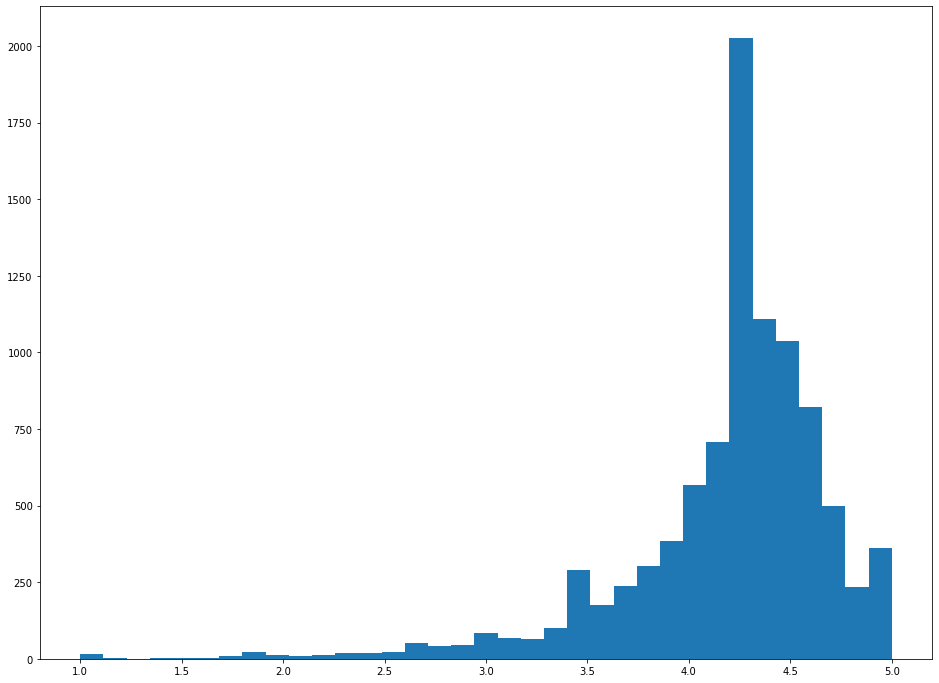

In [24]:
_ = apps_df['Rating'].hist(grid = False, figsize=(16,12), bins = 35)

### II. Histogram of `Reviews` Columns

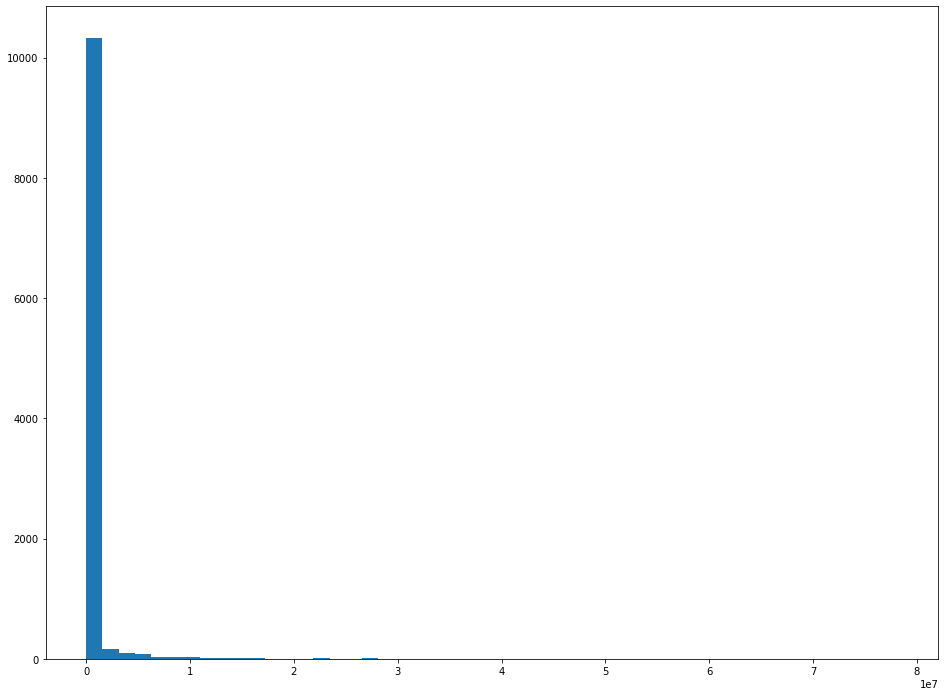

In [25]:
_ = apps_df['Reviews'].hist(grid = False, figsize=(16,12), bins = 50)

### III. Histogram of `Size` Columns

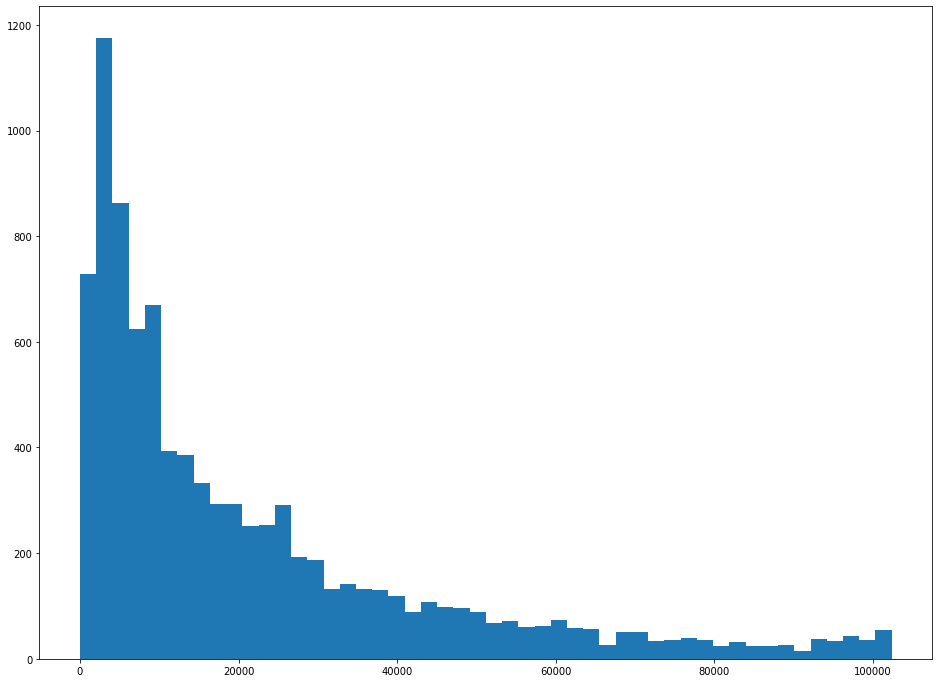

In [26]:
_ = apps_df['Size'].hist(grid = False, figsize=(16,12), bins = 50)

### IV. Histogram of `Installs` Columns

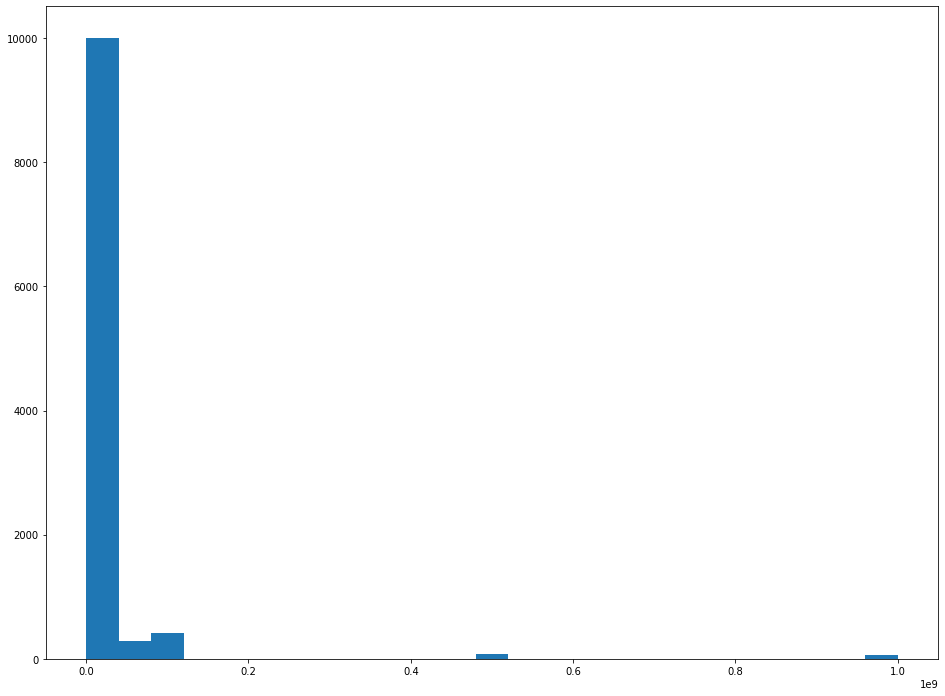

In [27]:
_ = apps_df['Installs'].hist(grid = False, figsize=(16,12), bins = 25)

## B. Bar Graphs

### I. Relation between `Category` & mean of `Size` Columns

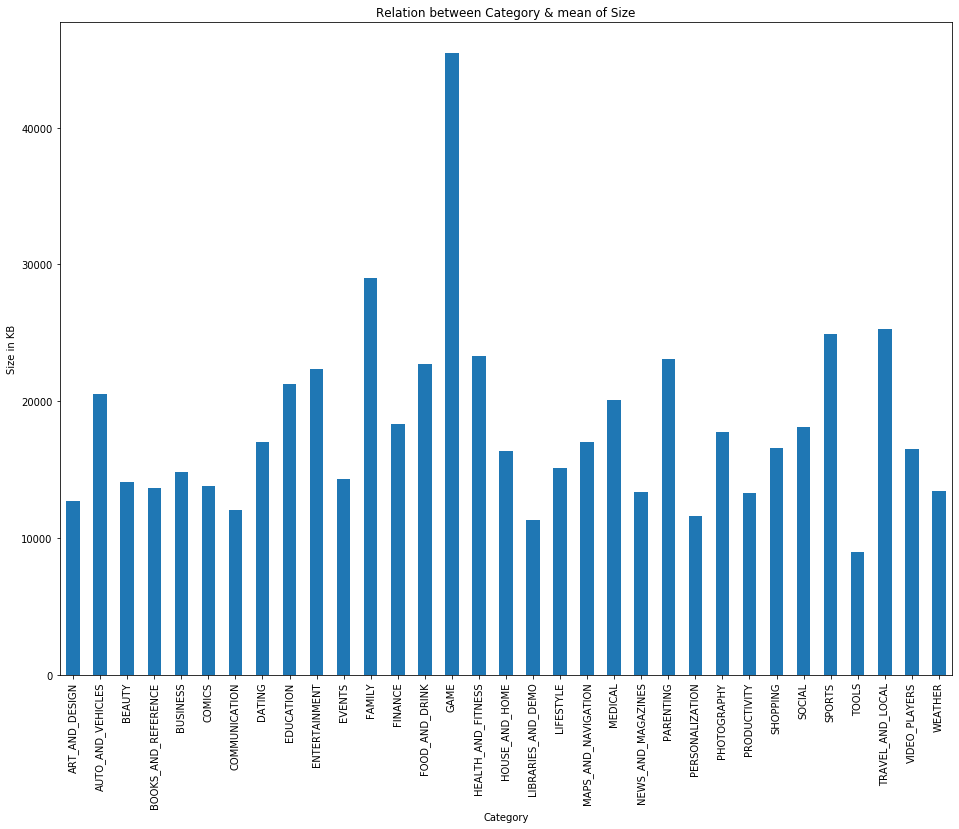

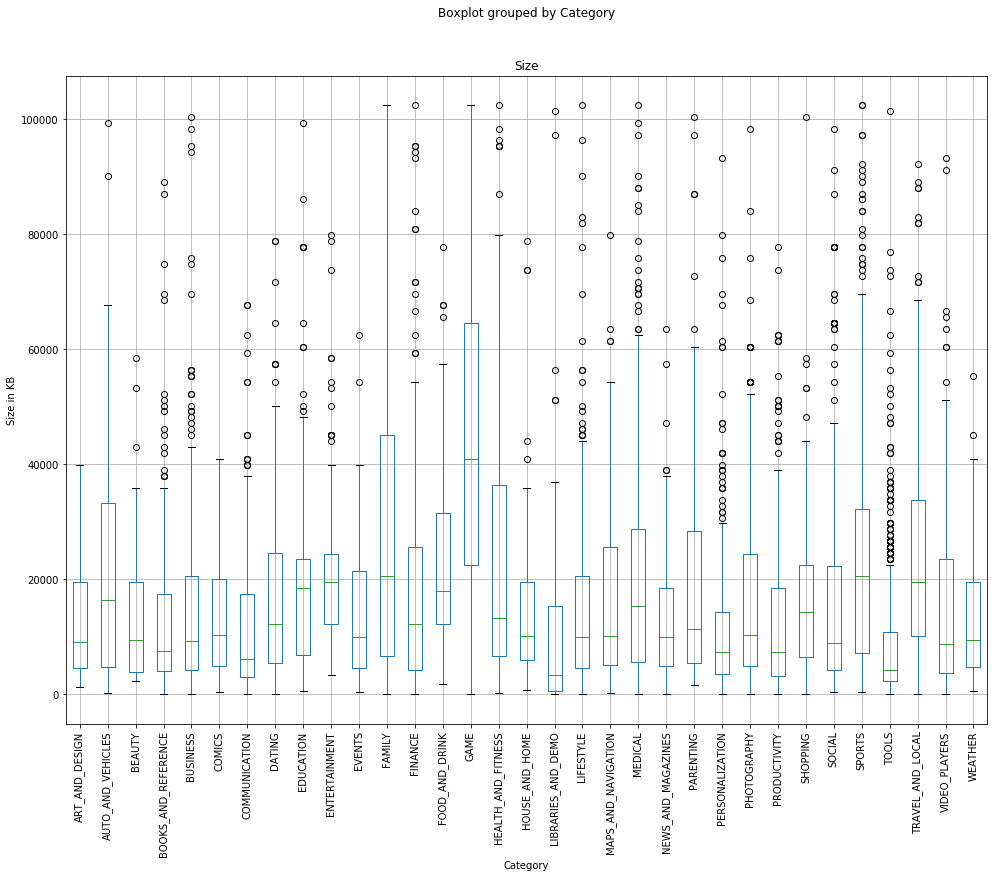

In [45]:
_ = apps_df.groupby('Category')['Size'].mean().plot(kind='bar', figsize=(16,12))
_ = plt.ylabel('Size in KB')
_ = plt.title('Relation between Category & mean of Size')

_ = apps_df.boxplot(column='Size', by='Category', figsize=(16,12), rot = 90)
_ = plt.ylabel('Size in KB')

### II. Relation between `Category` & mean of `Installs` Columns

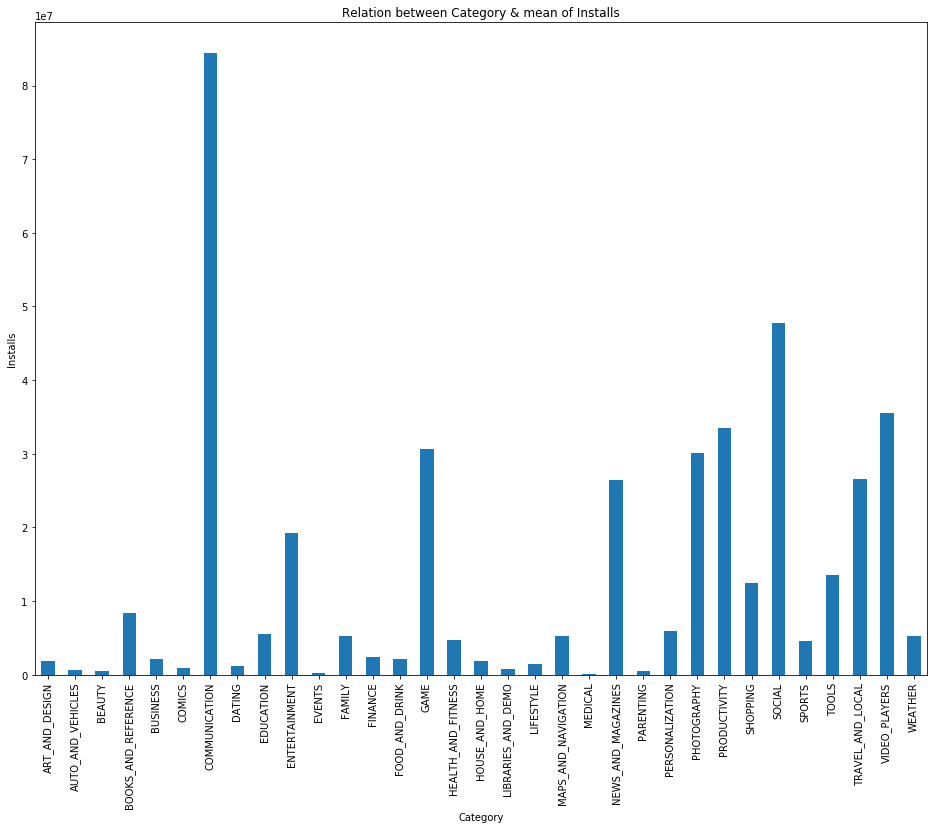

In [29]:
_ = apps_df.groupby('Category')['Installs'].mean().plot(kind='bar', figsize=(16,12))
_ = plt.ylabel('Installs')
_ = plt.title('Relation between Category & mean of Installs')

_ = apps_df.boxplot(column='Installs', by='Category', figsize=(16,12), rot = 90)
_ = plt.ylabel('Size in KB')

### III. Relation between `Type` & mean of `Installs` Columns

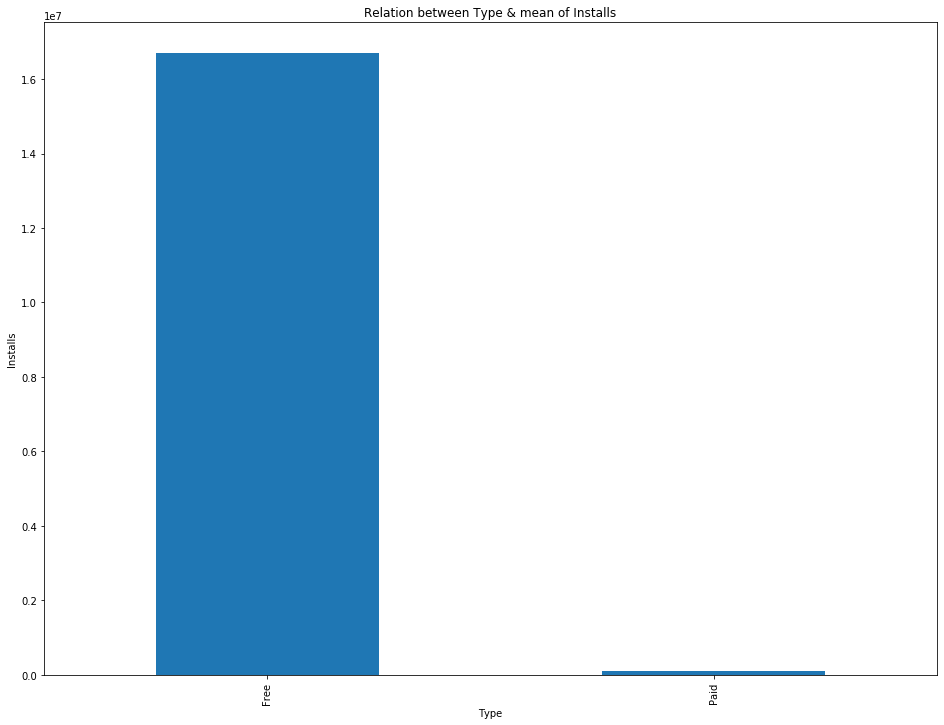

In [30]:
_ = apps_df.groupby('Type')['Installs'].mean().plot(kind='bar', figsize=(16,12))
_ = plt.ylabel('Installs')
_ = plt.title('Relation between Type & mean of Installs')

_ = apps_df.boxplot(column='Installs', by='Type', figsize=(16,12))
_ = plt.ylabel('Size in KB')

### IV. Relation between `Rating` & mean of `Reviews` Columns

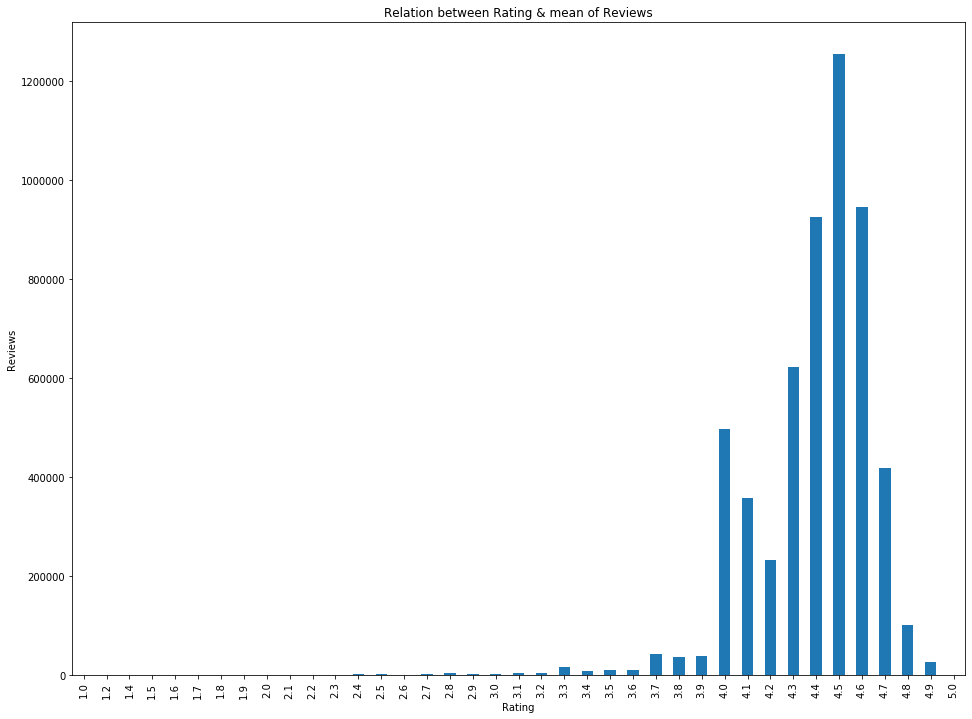

In [31]:
_ = apps_df.groupby('Rating')['Reviews'].mean().plot(kind='bar', figsize=(16,12))
_ = plt.ylabel('Reviews')
_ = plt.title('Relation between Rating & mean of Reviews')

_ = apps_df.boxplot(column='Reviews', by='Rating', figsize=(16,12), rot = 90)
_ = plt.ylabel('Size in KB')

### V. Relation between `Rating` & mean of `Installs` Columns

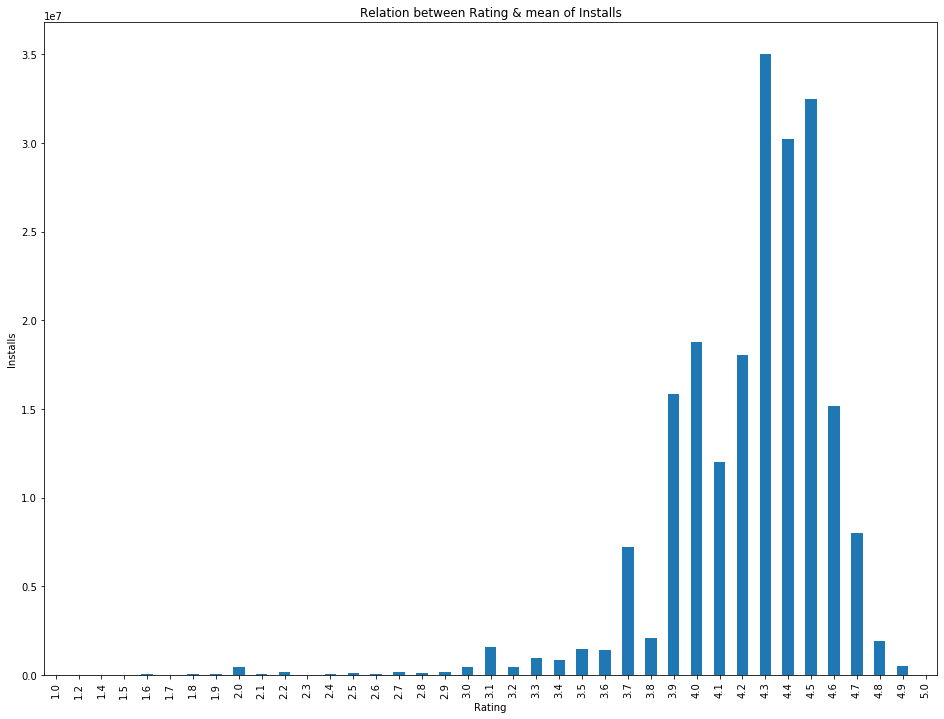

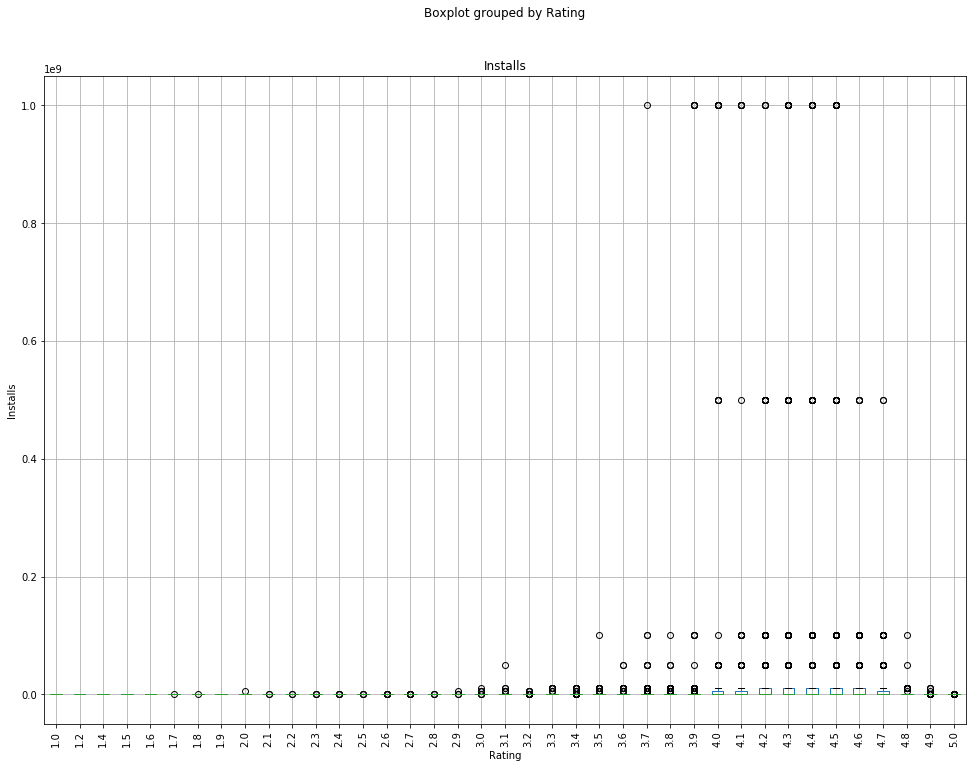

In [46]:
_ = apps_df.groupby('Rating')['Installs'].mean().plot(kind='bar', figsize=(16,12))
_ = plt.ylabel('Installs')
_ = plt.title('Relation between Rating & mean of Installs')

_ = apps_df.boxplot(column='Installs', by='Rating', figsize=(16,12), rot = 90)
_ = plt.ylabel('Installs')

## C. Correlation Matrix between all numerical columns

#### Scatter Plot

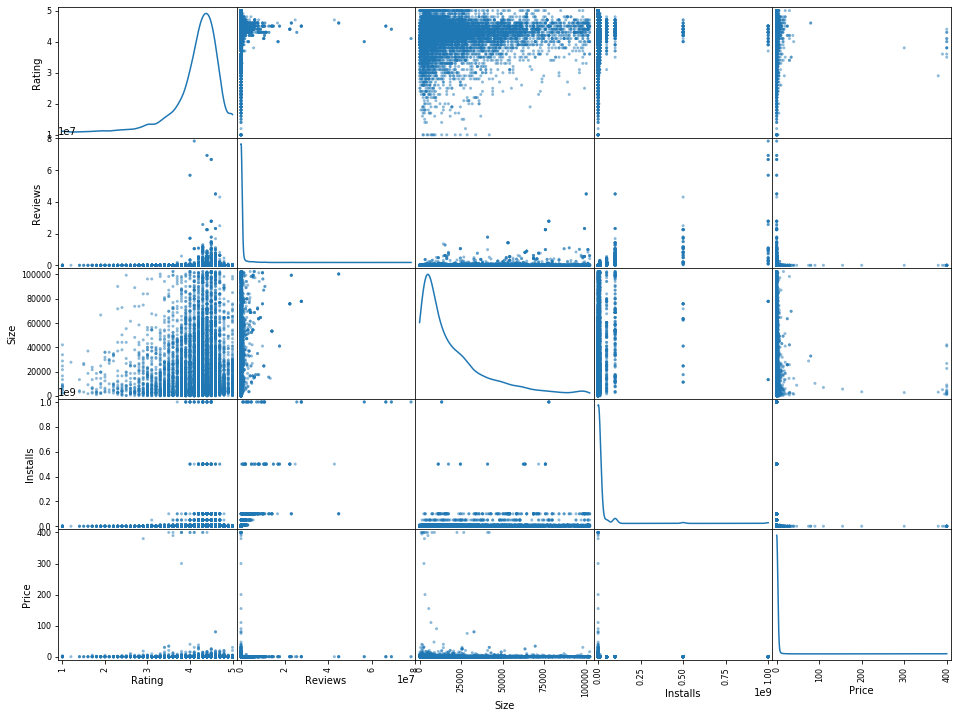

In [33]:
_ = pd.plotting.scatter_matrix(apps_df[apps_df.describe().columns], figsize=(16,12), diagonal='kde')

#### Heat Map

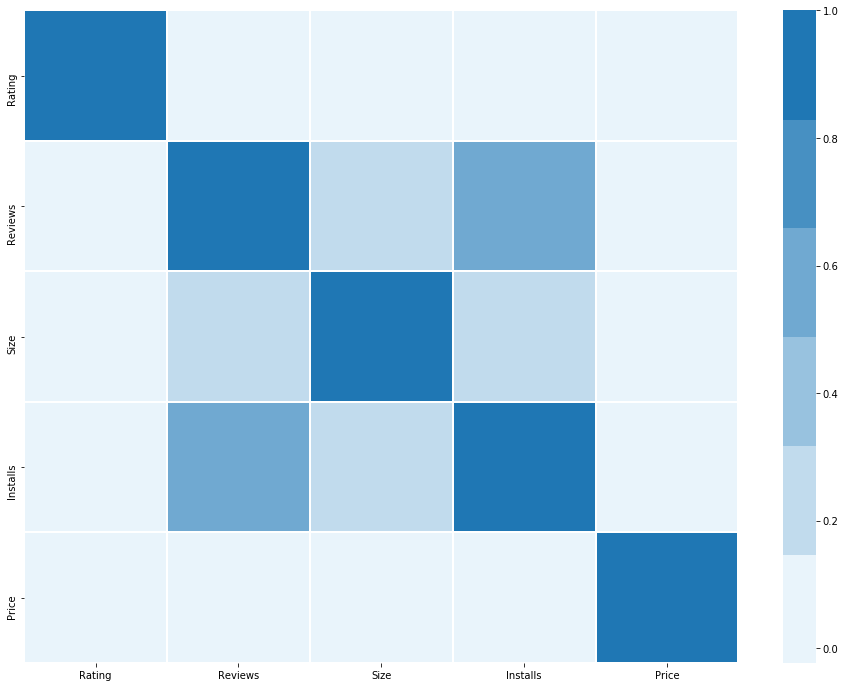

In [34]:
plt.subplots(figsize=(16, 12))
_ = sns.heatmap(
    apps_df[apps_df.describe().columns].corr(),
    cmap = sns.light_palette((31 / 255, 119 / 255, 180 / 255)),
    linewidths = 1
)

# 6. Data Transformation